In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import itertools
import numpy as np
%matplotlib inline

In [23]:
sys_args = ["../../results/quant/normCounts.tsv", "../../config/samples.tsv", "gene_list.tsv", "out_heatmap.png"]

def load_data(args):
    normcounts = pd.read_csv(args[0], sep="\t")
    metadata = pd.read_csv(args[1], sep="\t")
    gene_list = pd.read_csv(sys_args[2], sep="\t", header=None).iloc[:,0].to_list()
    out_file = args[3]
    return(normcounts, metadata, gene_list, out_file)

def plot_heatmap(normcounts, metadata, gene_list, out_file):
    
    counts_data = normcounts.query("GeneID in @gene_list").set_index("GeneID")
    cg = sns.clustermap(data=np.log2(counts_data))
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    print(f"Saving heatmap to {out_file}")
    plt.savefig(out_file)
    return(cg)

In [24]:
normcounts = pd.read_csv(sys_args[0], sep="\t")
gene_list = pd.read_csv(sys_args[2], sep="\t", header=None).iloc[:,0].to_list()
gene_list


['AGAP004707', 'AGAP006227', 'AGAP006228', 'AGAP006225', 'AGAP008818']

### Plot clustered heatmap 

Saving heatmap to out_heatmap.png


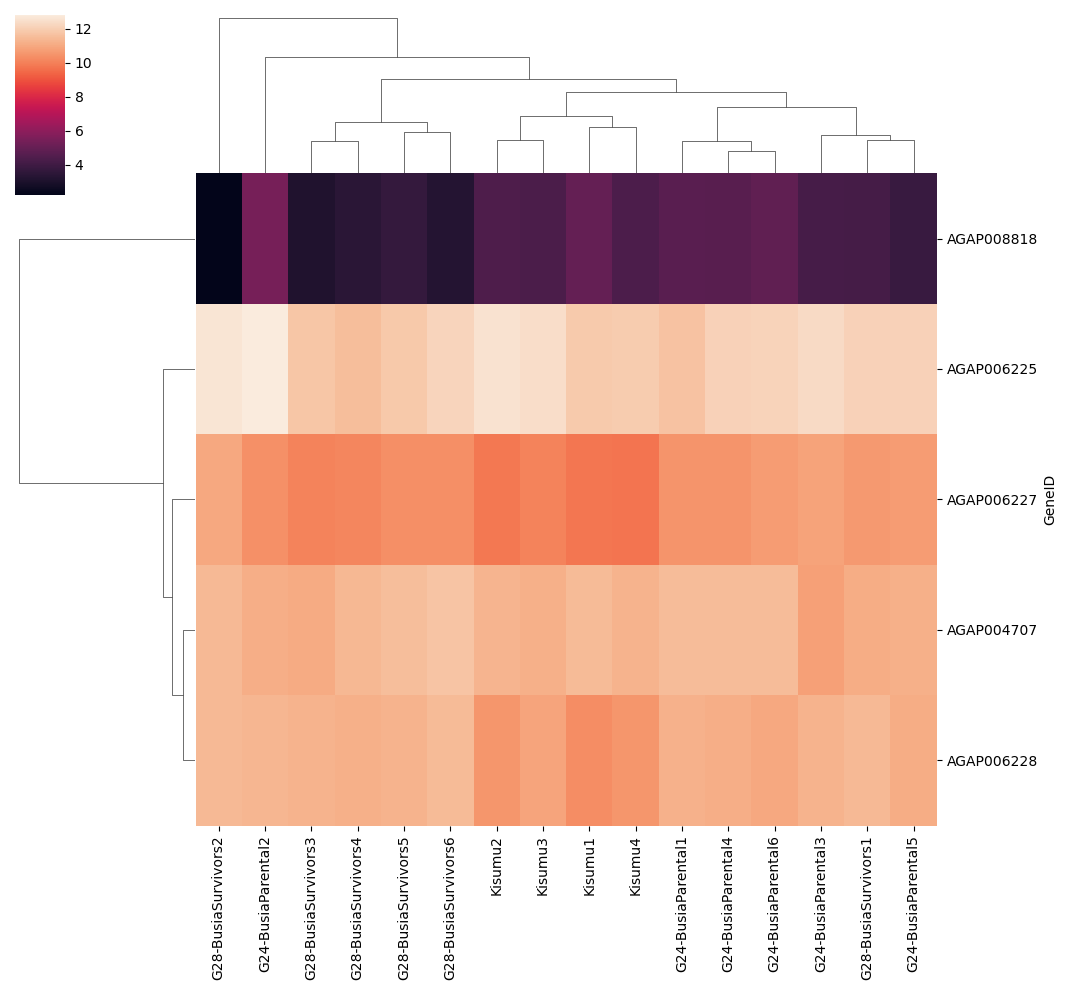

In [25]:
normCounts, metadata, gene_list, out_file = load_data(sys_args)

cg = plot_heatmap(normCounts, metadata, gene_list, out_file)

In [35]:
import rnaseqpoptools as rnaseqpop
import pandas as pd 
import matplotlib.pyplot as plt

# Read in parameters from snakemake
ploidy = 10
invs = ["2La", '2Rb']
metadata = pd.read_csv("../../config/samples.tsv", sep="\t")
metadata = metadata.sort_values(by='species')
dataset = "Ag_Busia"


karyo = {}
for inv in invs:
    df = pd.read_csv(f"../../results/karyotype/{inv}.{dataset}.karyo.txt", sep="\t")
    
    karyo[inv] = df[['sampleID', f"{inv} frequency"]]

# concat all the dfs in the dict and remove duplicate cols
karyo = pd.concat(karyo.values(), axis=1).T.drop_duplicates().T.set_index("sampleID")

## transpose and round to 2 decimals
karyo = karyo.T.astype("float64").round(1)
rnaseqpop.plotRectangular(karyo, path="../../results/karyotype/karyoFreqs.svg" , cmap='mako_r', ylab='Inversion', figsize=[18,4])

# Produce for average karyos per treatment
df = karyo.T.reset_index()
df = df.merge(metadata[['sampleID', 'treatment']])
df = df.groupby("treatment").agg('mean').T.astype("float64").round(2)
rnaseqpop.plotRectangular(df, path="../../results/karyotype/karyoOverallFreqs.svg", ylab='Inversion', cbar=False, figsize=[12,6])

In [ ]:
### Families 

In [36]:
#!/usr/bin/env python3

"""
Construct heatmap of different gene families
"""

import sys

import pandas as pd
import numpy as np
import scipy
from matplotlib.collections import LineCollection
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


In [69]:

#comparisons = pd.DataFrame(snakemake.params['DEcontrasts'], columns=['contrast'])

comparisons = ['G24-BusiaParental_G28-BusiaSurvivors', 'Kisumu_G24-BusiaParental', 'Kisumu_G28-BusiaSurvivors']

metadata = pd.read_csv("../../config/samples.tsv", sep="\t")

# Read in .csv file containing selection signals and associated metadata
pfam_df = pd.read_csv("../../resources/Anogam_long.pep_Pfamscan.seqs", sep="\s+", header=None)
go_df = pd.read_csv("../../resources/Anogam_long.pep_eggnog_diamond.emapper.annotations.GO", sep="\t", header=None)

pfam_df.columns = ["transcript", "pstart", "pend", "pfamid", "domain", "domseq"]
go_df.columns = ['transcript', 'GO_terms']

gene_annot_df = pfam_df.merge(go_df)
gene_annot_df.loc[:, 'gene_id'] = gene_annot_df.loc[:, 'transcript'].str.replace("Anogam_", "").str.replace("-R[A-Z]", "")

# load normalised counts 
counts = pd.read_csv("../../results/quant/normCounts.tsv", sep="\t")


## define functions ## 

def plot_rotated_dendro(dendro, ax, linewidth=2):
    coords = zip(dendro['dcoord'], dendro['icoord'])
    lines = LineCollection([list(zip(x, y)) for x, y in coords], colors='lightgray', linewidth=linewidth)

    ax.add_collection(lines)
    number_of_leaves = len(order)
    max_dependent_coord = max(map(max, dendro['dcoord']))


    ax.yaxis.set_ticks_position('right')

    # Constants 10 and 1.05 come from
    # `scipy.cluster.hierarchy._plot_dendrogram`
    ax.set_ylim(0, number_of_leaves * 10)
    ax.set_xlim(0, max_dependent_coord * 1.05)

    ax.invert_xaxis()
    ax.invert_yaxis()

    sns.despine(ax=ax, bottom=True, left=True, right=True)
    ax.tick_params(top=False,
                   bottom=False,
                   left=False,
                   right=False,
                labelleft=False,
                   labelright=False,
                   labelbottom=False)
    return(ax)

def gene_ids_from_domain(gene_annot_df, domain):
    gene_list = []
    if isinstance(domain, list):
        for dom in domain:
            ids = gene_annot_df.query("domain == @domain")['gene_id']
            gene_list.append(ids)
            return(np.unique(gene_list))
    else:
        return(gene_annot_df.query("domain == @domain")['gene_id'].to_numpy())





/home/sanj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


In [70]:
### MAIN
# a dict with gene families and their respective Pfam domain for extracting
gene_fams = {'COE': 'COesterase', 
             'OBP':'PBP_GOBP', 
             'OR':'7tm_6', 
             'Io':['Lig_chan','7tm_1'],
             'Gr': '7tm_7',
             'P450':'p450', 
             'Gst':['GST_N', 'GST_N_3', 'GST_C'], 
             'ABC':['ABC_membrane', 'ABC_tran'],
            'FAS':'ketoacyl-synt',
            'ELO':'ELO',
            'FAD':'FA_desaturase',
            'FAR':'NAD_binding_4'}


### read in diff exp data
genediff = {}
counts_dict = {}
for comp in comparisons:
    print(comp)
    df = pd.read_csv(f"../../results/genediff/{comp}.csv", sep=",")
    names = df[['GeneID', 'GeneName']]#, 'GeneDescription']]
    genediff[comp] = df
    
    #loop through gene fams 
    fam_dict = {}
    for fam, domain in gene_fams.items():
        gene_ids = gene_ids_from_domain(gene_annot_df, domain)
        fam_de = df.query("GeneID in @gene_ids").copy()
        
        fam_de.loc[:, 'de'] = np.where(
             np.logical_and(fam_de['padj'].between(0, 0.05, inclusive="both"), fam_de['FC'].ge(1)), 
            'Upregulated', 
             np.where(
                     np.logical_and(fam_de['padj'].between(0, 0.05, inclusive="both"), fam_de['FC'].le(1)), 'Downregulated', 'No Diff. expression'
             )
        )
        
        fam_dict[fam] = fam_de
        counts_dict[fam] = counts.query("GeneID in @gene_ids")
        counts_dict[fam] = counts_dict[fam].merge(names)
        counts_dict[fam].loc[:, 'Label'] = [id_ + " | " + name if name != "" else id_ for id_, name in zip(counts_dict[fam]['GeneID'].fillna(""), counts_dict[fam]['GeneName'].fillna(""))]
        
    genediff[comp] = dict(fam_dict)



G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors


In [71]:

colors = ["#d9d9d9", '#33cc33', '#cc66ff']
pal = sns.color_palette(colors)

def remap(x):
    if x == 'Upregulated':
        return(1)
    elif x == 'Downregulated':
        return(2)
    elif x == 'No Diff. expression':
        return(0)
    else:
        assert x == 'Nan', "whats wrong with x"
    

def check_fcs(diffexp, fam, comparisons):
    
    idx = np.random.choice(diffexp.shape[0])
    gene = diffexp['GeneID'][idx]
    
    vals = diffexp.set_index('GeneID').query("GeneID == @gene").to_numpy()[0]
    
    comp_vals = []
    for comp in comparisons:
        row = genediff[comp][fam].query("GeneID == @gene")
        if row['padj'].to_numpy() < 0.05:
            if row['FC'].to_numpy() > 1:
                comp_vals.append(1)
            elif row['FC'].to_numpy() < 1:
                comp_vals.append(2)
        else:
            comp_vals.append(0)
    
    assert all(np.array(comp_vals) == vals), "The values do not match! ffs"



In [77]:
label_comps = [c.replace("_", " v\n").replace("G24-", "").replace("G28-", "") for c in comparisons]

In [79]:

with PdfPages("../../results/genediff/GeneFamiliesHeatmap2.pdf") as pdf:

    for fam, domain in gene_fams.items():

        ids = counts_dict[fam]['GeneID'].to_numpy()
        diffexp = counts_dict[fam]['GeneID'].to_frame().copy()

        for comp in comparisons:
            print(comp)
            de_data = genediff[comp][fam].set_index("GeneID").reindex(ids).reset_index()
            assert all(diffexp['GeneID'].to_numpy() == de_data['GeneID'].to_numpy()), "wrong!!"
            diffexp.loc[:, comp] = de_data['de']

        diffexp_remap = diffexp.set_index("GeneID").reindex(index=ids)
        diffexp_remap = diffexp_remap.applymap(remap)
        check_fcs(diffexp_remap.reset_index(), fam, comparisons)

        df = counts_dict[fam].set_index("Label").drop(columns=['GeneID', 'GeneName'])
        size = len(df)

        g = sns.clustermap(data=np.log2(df+1), 
                        cmap="Blues", 
                        vmax=10, 
                        cbar=False,
                        linewidths=4,
                        col_cluster=False,
                        linecolor="white",
                        yticklabels=False, xticklabels=False,
                        tree_kws=dict(linewidths=3, colors="lightgray"),
                        figsize=[1, 1])
        ax = g.ax_heatmap
        ax.set_ylabel("")
        dendro = g.ax_row_dendrogram
        g.ax_cbar.set_visible(False)
        g.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
        g.ax_col_dendrogram.set_visible(False) #suppress column dendrogram

        order = g.dendrogram_row.reordered_ind

        diffexp_remap = diffexp_remap.iloc[order, :]
        assert all(diffexp_remap.index == df.iloc[order, :].index.str[:10].to_list()), "rows do not match"

        df = df.T.assign(sampleID=df.T.index)
        df.loc[:, 'treatment'] = df['sampleID'].str.slice(stop=-1) #TODO fix dont replace numbers
        #df.loc[:, 'treatment'] = df['sampleID'].str.replace("[\d+]", "", regex=True) #TODO fix dont replace numbers
        n_treatments = len(df.loc[:, 'treatment'].unique())

#        fig, ax = plt.subplots(1, n_treatments+2, figsize=[10,(size/3)], gridspec_kw={'width_ratios':[3, 3] + list(np.repeat(1, n_treatments))})
        fig, ax = plt.subplots(1, n_treatments+2, figsize=[10,(size/3)], gridspec_kw={'width_ratios':[9, 9, 3, 3, 2]})
        fig.suptitle(f"{fam}, pfam domains = {domain}", fontsize=18, fontweight='bold')
        dendro = scipy.cluster.hierarchy.dendrogram(g.dendrogram_row.linkage, no_plot=True,
                                                        above_threshold_color='lightgray', 
                                                        color_threshold=0, 
                                                        no_labels=True)
        ax[0] = plot_rotated_dendro(dendro, ax[0])
        sns.heatmap(ax=ax[1], data=diffexp_remap, cmap=pal, cbar=False, linewidths=4, linecolor='white')
        ax[1].set_xticklabels(label_comps, fontsize=14, fontweight='bold')
        ax[1].set_ylabel("")

        for idx, group in enumerate(metadata.treatment.unique()):
            idx = idx+2
            df2 = df.query("treatment == @group").drop(columns=['treatment', 'sampleID'])
            df2 = df2.T.iloc[order, :]

            sns.heatmap(ax=ax[idx], data=np.log10(df2+1), cmap="Blues", cbar=False, linewidths=4, linecolor='white')

            ax[idx].set_xlabel(group, rotation=90, fontsize=14, fontweight='bold', ha='right', rotation_mode='anchor')
            ax[idx].set_xticklabels([])
            ax[idx].set_ylabel("")
            ax[idx].tick_params(top=False,
                                bottom=False,
                                left=False,
                                right=False,
                                labelleft=False,
                                labelright=True,
                                labelbottom=True)

            sns.despine(left=True, bottom=True, right=True)
            ax[idx].set_yticklabels(labels=df2.index, rotation=0,fontsize=14)
        for axes in ax[1:-1]:
            axes.set_yticklabels([])
            axes.set_yticks([])

        fig.savefig(f"../../results/genediff/{fam}.tiff", dpi=100, bbox_inches="tight")
        pdf.savefig(bbox_inches = 'tight')

G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors
G24-BusiaParental_G28-BusiaSurvi

In [ ]:
### VENN DIAGRAMS

In [17]:
#!/usr/bin/env python3


import itertools
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3


direction = "down"


pval = 0.05
dataset = "Ag_Busia"
comparisons = ['G24-BusiaParental_G28-BusiaSurvivors', 'Kisumu_G24-BusiaParental', 'Kisumu_G28-BusiaSurvivors']

#comparisons.append([f'{c.split("_")[1]}_{c.split("_")[0]}' for c in comparisons])

assert len(comparisons) > 1, "Only one differential expression comparison is specified, cannot run venn analysis. Please disable venn in config.yaml or specify more comparisons"


In [18]:

de_data = {}
de_genes = {}
for de_comp in comparisons:

    alt_comp = f'{de_comp.split("_")[1]}_{de_comp.split("_")[0]}'
    n_comps = len(comparisons)
    
    print(de_comp)
    de_data[de_comp] = pd.read_csv(f"../../results/genediff/{de_comp}.csv")

    de_genes[alt_comp] = de_data[de_comp].query(f"padj < {pval}")
    de_genes[de_comp] = de_data[de_comp].query(f"padj < {pval}")

    if direction == 'up':
        de_genes[de_comp] = de_genes[de_comp].query("FC > 1")['GeneID'].to_numpy()
    elif direction == 'down':
        de_genes[de_comp] = de_genes[de_comp].query("FC < 1")['GeneID'].to_numpy()
    
    if direction == 'up':
        de_genes[alt_comp] = de_genes[alt_comp].query("FC < 1")['GeneID'].to_numpy()
    elif direction == 'down':
        de_genes[alt_comp] = de_genes[alt_comp].query("FC > 1")['GeneID'].to_numpy()          
            


G24-BusiaParental_G28-BusiaSurvivors
Kisumu_G24-BusiaParental
Kisumu_G28-BusiaSurvivors


In [19]:
plt.close()

In [15]:

for comp1, comp2 in itertools.combinations(comparisons, 2):
    all_de_comps = [comp1, comp2]
    all_de_comps_string = '.'.join(all_de_comps)
    all_de_comps = [a.replace("_", " v ") for a in all_de_comps]

    de1 = set(de_genes[comp1])
    de2 = set(de_genes[comp2])

    s = [de1, de2]
    venn2(s, all_de_comps)
    plt.title(f"Venn - {all_de_comps_string} - {direction}")
    plt.savefig(f"../../results/genediff/venn/{all_de_comps_string}-{direction}-Venn.png", bbox_inches = 'tight')
    plt.close()


In [16]:

if n_comps >= 3:
    for all_de_comps in itertools.combinations(comparisons, 3):
        comp1, comp2, comp3 = all_de_comps
        all_de_comps_string = '.'.join(all_de_comps)
        all_de_comps = [a.replace("_", " v ") for a in all_de_comps]

        de_genes2 = dict((k, de_genes[k]) for k in (comp1, comp2, comp3))

        s = [set(v) for v in de_genes2.values()]

        venn3(s, all_de_comps)
        plt.title(f"Venn - {all_de_comps_string} - {direction}")
        plt.savefig(f"../../results/genediff/venn/{all_de_comps_string}-{direction}-Venn.png", bbox_inches = 'tight')
        plt.close()